In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.decomposition import PCA

from deeptime.decomposition import VAMP
from deeptime.data import ellipsoids
from deeptime.decomposition import TICA
from deeptime.util.types import to_dataset
from deeptime.kernels import GaussianKernel

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

## Hyperparameters

In [2]:
LAGTIME = 250
DIM = 5

## Data

In [3]:
X_train_df = pd.read_csv('data/X_train.csv', index_col=0, sep=',')
X_train_df.columns.name = 'date'

Y_train = pd.read_csv('data/Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

print(f'Shape of training set X is {X_train_df.shape}')
print(f'Shape of training set Y is {Y_train.shape}')

Shape of training set X is (50, 754)
Shape of training set Y is (50, 504)


In [4]:
data = X_train_df.values.T
x_o, x_t = to_dataset(data, lagtime=LAGTIME)[:]

In [5]:
def compute_metric(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """
    Computes a similarity metric between predicted and true values.

    Args:
        y_pred (np.ndarray): Predicted values of size m x T where T > m.
        y_true (np.ndarray): Ground truth values of size m x T where T > m.

    Returns:
        float: Mean similarity metric.
    """
    y_pred_scaled = y_pred / np.linalg.norm(y_pred, axis=0, keepdims=True)
    y_true_scaled = y_true / np.linalg.norm(y_true, axis=0, keepdims=True)
    total = np.sum(y_pred_scaled * y_true_scaled, axis=0)
    return np.mean(total)

def compute_predictions(basis: np.ndarray, x_t: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Fit a linear regression model
    beta = np.linalg.inv(basis.T @ basis) @ basis.T @ x_t

    # Predict the future values
    x_t_pred = basis @ beta

    # compute the similarity metric
    metric = compute_metric(x_t_pred.T, x_t.T)

    # scores
    print(f"Similarity metric: {metric:.4f}")

    return x_t_pred, beta

## TICA

In [6]:
tica = TICA(lagtime=LAGTIME, dim=DIM)
tica.fit(data)
tica_model = tica.fetch_model()
print(f'Score is {tica_model.score(r=2):.4f}')

# Transform the data using TICA
tica_projection = tica_model.transform(x_t)

tica_x_t_pred, tica_beta = compute_predictions(tica_projection, x_t)

Score is 1.6151
Similarity metric: 0.2867


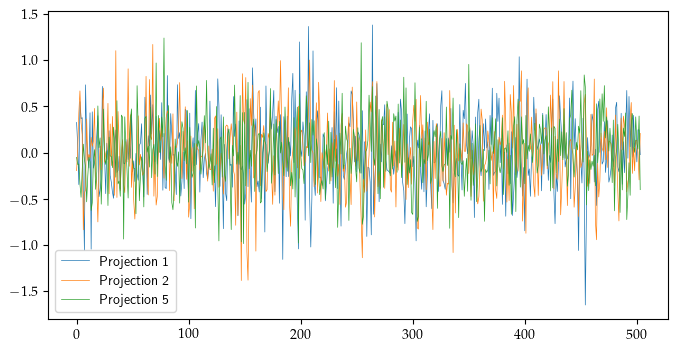

In [7]:
plt.figure(figsize=(8,4))
plt.plot(tica_projection[:,0], lw = 0.5, label = 'Projection 1')
plt.plot(tica_projection[:,1], lw = 0.5, label = 'Projection 2')
plt.plot(tica_projection[:,DIM-1], lw = 0.5, label = f'Projection {DIM}')
plt.legend()
plt.show()

## VAMP

In [ ]:
vamp = VAMP(lagtime=LAGTIME, dim=DIM)
vamp.fit(data)
vamp_model = vamp.fetch_model()
print(f'Score is {vamp_model.score(r=2):.4f}')

# Transform the data
vamp_projection = vamp_model.transform(x_t)

vamp_x_t_pred, vamp_beta = compute_predictions(vamp_projection, x_t)

Score is 2.4692
Similarity metric: 0.2984


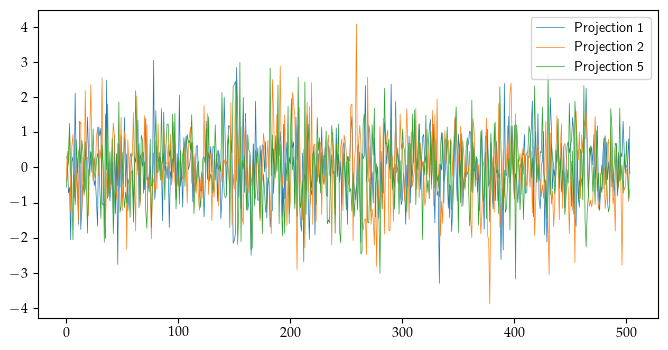

In [9]:
plt.figure(figsize=(8,4))
plt.plot(vamp_projection[:,0], lw = 0.5, label = 'Projection 1')
plt.plot(vamp_projection[:,1], lw = 0.5, label = 'Projection 2')
plt.plot(vamp_projection[:,DIM-1], lw = 0.5, label = f'Projection {DIM}')
plt.legend()
plt.show()

## PCA

In [10]:
pca = PCA(n_components=DIM).fit(data)

# compute pca projections
pca_projection = pca.transform(x_t)

# compute predictions using PCA
pca_x_t_pred, pca_beta = compute_predictions(pca_projection, x_t)

Similarity metric: 0.5888


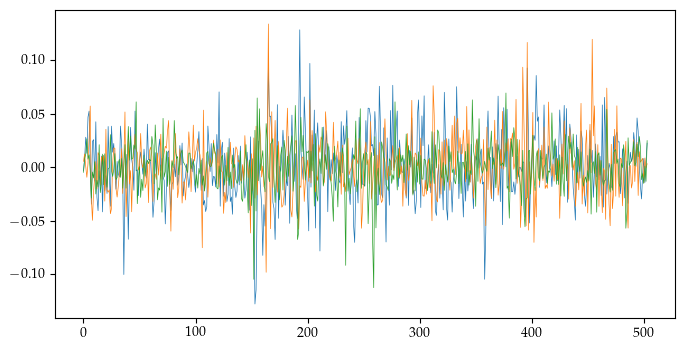

In [11]:
plt.figure(figsize=(8,4))
plt.plot(pca_projection[:,0], lw = 0.5, label = 'Projection 1')
plt.plot(pca_projection[:,1], lw = 0.5, label = 'Projection 2')
plt.plot(pca_projection[:,DIM-1], lw = 0.5, label = f'Projection {DIM}')
plt.show()

## KernelCCA

In [12]:
from deeptime.decomposition import KernelCCA
from deeptime.decomposition import vamp_score_data

In [13]:
sigma = 1.0
kernel = GaussianKernel(sigma)

kcca = KernelCCA(kernel, n_eigs=DIM, epsilon=1e-3)
kcca.fit((x_o, x_t))
kcca_model = kcca.fetch_model()

# compute kcca projections
kcca_projection = kcca_model.transform(x_t)

# compute predictions using KCCA
kcca_x_t_pred, kcca_beta = compute_predictions(kcca_projection, x_t)

Similarity metric: 0.4555


In [14]:
transform = lambda x: kcca_model.transform(x).real
kcca_score = vamp_score_data(x_o, x_t, transform, r=2)
print(f'Score is {kcca_score:.4f}')

Score is 1.0885


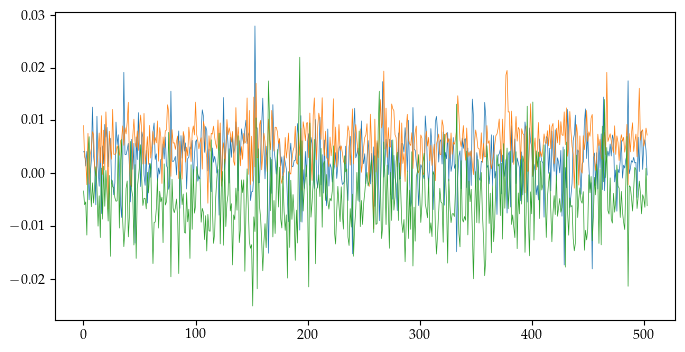

In [15]:
plt.figure(figsize=(8,4))
plt.plot(kcca_projection[:,0], lw = 0.5, label = 'Projection 1')
plt.plot(kcca_projection[:,1], lw = 0.5, label = 'Projection 2')
plt.plot(kcca_projection[:,DIM-1], lw = 0.5, label = f'Projection {DIM}')
plt.show()

## VAMPNets

In [16]:
import torch
import torch.nn as nn
from deeptime.util.torch import MLP
from deeptime.util.data import TrajectoryDataset
from deeptime.decomposition.deep import VAMPNet
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

In [18]:
traj = data

In [19]:
dataset = TrajectoryDataset(1, traj.astype(np.float32))

In [20]:
n_val = int(len(dataset)*.5)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [21]:
len(val_data)

376

In [22]:

lobe = MLP(units=[traj.shape[1], 15, 10, 10, 5, DIM], nonlinearity=nn.Tanh)

In [23]:
lobe

MLP(
  (_sequential): Sequential(
    (0): Linear(in_features=50, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Tanh()
    (8): Linear(in_features=5, out_features=5, bias=True)
  )
)

In [24]:
lobe = lobe.to(device=device)

In [25]:
vampnet = VAMPNet(lobe=lobe, learning_rate=1e-4, epsilon=1e-6, device=device)

In [26]:
loader_train = DataLoader(train_data, batch_size=16, shuffle=True)
loader_val = DataLoader(val_data, batch_size=16, shuffle=False)

In [27]:
model = vampnet.fit(loader_train, n_epochs=160, validation_loader=loader_val, progress=tqdm)

VAMPNet epoch:   0%|          | 0/160 [00:00<?, ?it/s]

In [28]:
vampnet_model = model.fetch_model()

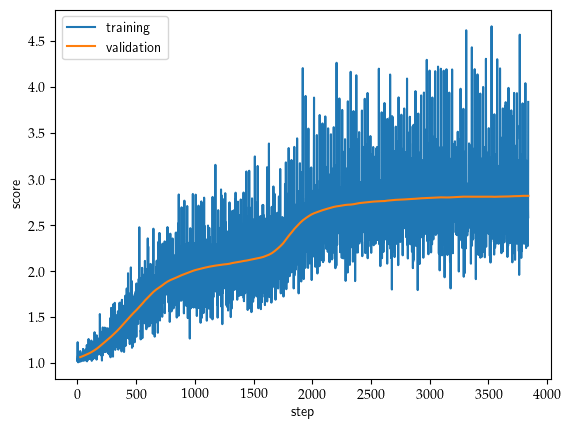

In [35]:
plt.plot(*vampnet.train_scores.T, label='training')
plt.plot(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()
plt.show()

In [30]:
feat = vampnet_model.transform(traj)

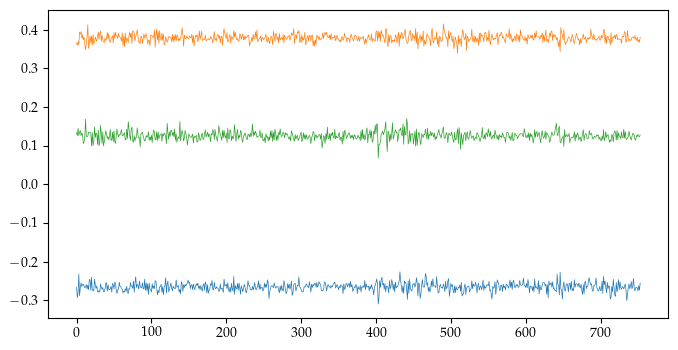

In [33]:
plt.figure(figsize=(8,4))
plt.plot(feat[:,0], lw = 0.5, label = 'Projection 1')
plt.plot(feat[:,1], lw = 0.5, label = 'Projection 2')
plt.plot(feat[:,DIM-1], lw = 0.5, label = f'Projection {DIM}')
plt.show()

In [37]:
# Transform the data
vampnet_projection = vampnet_model.transform(x_t)

vampnet_x_t_pred, vampnet_beta = compute_predictions(vampnet_projection, x_t)

Similarity metric: 0.4609
